In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage import exposure
import cv2
from sklearn.cluster import KMeans
from tqdm import tqdm
import pickle

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


import pickle
from sklearn.decomposition import PCA 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import cv2

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Add, AvgPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D,Flatten,MaxPool2D,BatchNormalization,GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

sns.set_style('darkgrid')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

from google.colab.patches import cv2_imshow

# **Functions**

In [3]:
def read_image_path(path):

  ball_type = [_ for _ in os.listdir(path)]

  df = {'file_path': [], 'label': []}
  df = pd.DataFrame(df) 

  for i in range(len(ball_type)):
    for file in os.listdir(path+ball_type[i]):
      new_row = {
                  'file_path': path + ball_type[i] + '/' + file,
                  'label': ball_type[i]
                }
      df = df.append(new_row, ignore_index=True)
      
  return df

In [4]:
def read_image(train_df, test_df):

  X_train, y_train, X_test, y_test = [], [], [], []

  target_size = (32, 32)

  train_df.reset_index(drop=True, inplace=True)
  for i in range(len(train_df)):
    img = cv2.imread(train_df.loc[i, 'file_path'])
    img_resized = cv2.resize(img, target_size)
    label = train_df.loc[i, 'label']

    X_train.append(img_resized)
    y_train.append(label)
    
  test_df.reset_index(drop=True, inplace=True)
  for i in range(len(test_df)):
    img = cv2.imread(test_df.loc[i, 'file_path'])
    img_resized = cv2.resize(img, target_size)
    label = test_df.loc[i, 'label']

    X_test.append(img_resized)
    y_test.append(label)

  return X_train, X_test, y_train, y_test

# Feature extraction functions

In [5]:
# FUNCTIONS FOR FEATURE EXTRACTION

# Flatten image
def flatten(X_train, X_test):
    X_train_flatten, X_test_flatten = [], []
    for i in range(len(X_train)):
        X_train_flatten.append(X_train[i].flatten())
    for i in range(len(X_test)):
        X_test_flatten.append(X_test[i].flatten())
    return X_train_flatten, X_test_flatten


# Use color histogram
def histogram_color(X_train, X_test):
    mask = None
    bin = [8, 8, 8]
    X_train_hist, X_test_hist = [], []

    for i in range(len(X_train)):
        lab = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2LAB)
        hist = cv2.calcHist([lab], [0,1,2], mask, bin, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        X_train_hist.append(hist)

    for i in range(len(X_test)):
        lab = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2LAB)
        hist = cv2.calcHist([lab], [0,1,2], mask, bin, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        X_test_hist.append(hist)

    return X_train_hist, X_test_hist


# Use color channel statistic (mean and std)
def color_channel(X_train, X_test):
    X_train_meanstd, X_test_meanstd = [], []

    for i in range(len(X_train)):
        mean, std = cv2.meanStdDev(X_train[i])
        features = np.concatenate([mean, std]).flatten()
        X_train_meanstd.append(features)

    for i in range(len(X_test)):
        mean, std = cv2.meanStdDev(X_test[i])
        features = np.concatenate([mean, std]).flatten()
        X_test_meanstd.append(features)

    return X_train_meanstd, X_test_meanstd

# Canny 
def Canny(X_train, X_test):
    
    X_train_canny, X_test_canny = [], []
    target_size = (32, 32)

    def CannyPreprocess(image, target_size):
        image = cv2.resize(image, target_size)

        pictureGray = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)
        pictureCanny = cv2.Canny(pictureGray, 50, 100)

        pictureDilate = cv2.dilate(pictureCanny, None, iterations=20)
        pictureErode = cv2.erode(pictureDilate, None, iterations=5)
        imask2 = pictureErode>0
        canvas = np.full_like(image, np.array([255,0,0]), dtype=np.uint8)
        canvas[imask2] = image[imask2]
        def convert_to_1D(image):
            return np.reshape(image, image.shape[0] * image.shape[1] * image.shape[2])
        return convert_to_1D(canvas)
    
    for i in range(len(X_train)):
        X_train_canny.append(CannyPreprocess(X_train[0], target_size))
    
    for i in range(len(X_test)):
        X_test_canny.append(CannyPreprocess(X_test[0], target_size))
    
    return X_train_canny, X_test_canny

In [6]:
def feature_extraction(X_train, X_test, method):

    if method == 'flatten':
        X_train_new, X_test_new = flatten(X_train, X_test)

    elif method == 'histogram':
        X_train_new, X_test_new = histogram_color(X_train, X_test)

    elif method == 'color_channel':
        X_train_new, X_test_new = color_channel(X_train, X_test)
    elif method == 'canny':
        X_train_new, X_test_new = Canny(X_train, X_test)

    return X_train_new, X_test_new

In [7]:
def oversampling(train_df):
  
  count_max = max(train_df['label'].value_counts())
  samples = []

  for category in train_df['label'].unique():
    category_slice = train_df.query("label == @category")
    samples.append(category_slice.sample(count_max, replace=True, random_state=1))

  train_df_oversampled = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index()

  return train_df_oversampled

In [8]:
def model_development(X_train, X_test, y_train, y_test):

  pca = PCA(n_components=0.99, random_state=42)

  svc = SVC(random_state=42)
  pca_svc = make_pipeline(pca, svc)


  rf = RFC(random_state=42)
  pca_rf = make_pipeline(pca, rf)

  lr = LogisticRegression(random_state=42, max_iter=3000)
  pca_lr = make_pipeline(pca, lr)

  classifiers = [svc, pca_svc, rf, pca_rf, lr, pca_lr]

  df_score = pd.DataFrame({'model': [], 'accuracy': [], 'f1-macro': []})

  for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    df_score = df_score.append({'model': str(classifier), 'accuracy': accuracy_score(y_pred, y_test), 'f1-macro': f1_score(y_test, y_pred, average="macro")}, ignore_index=True)
  
  N, train_lc, val_lc = learning_curve(rf, X_train, y_train, cv=5, train_sizes=np.linspace(0.3, 1, 25))
  # plt.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
  # plt.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
  # plt.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
  #               color='gray', linestyle='dashed')
  # plt.legend()
  # plt.title()
  # plt.xlabel('Training examples')
  # plt.ylabel('Score')
  # plt.show()

  return df_score

In [9]:
def resnet_model(train_df, test_df, X_train):
    batch_size = len(train_df)
    # print('Train_df: ', train_df)
    
    img_height = 32
    img_width = 32
    target_size = (img_height, img_width)
    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)
    test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

    train_generator = train_datagen.flow_from_dataframe(train_df, directory=train_path, x_col='file_path', y_col='label',
                                                        target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
    test_generator = test_datagen.flow_from_dataframe(test_df, directory=train_path, x_col='file_path', y_col='label',
                                                        target_size=target_size, batch_size=len(test_df), color_mode='rgb', class_mode='categorical')
    
    def build_model(input_shape, classes):
        input = Input(shape=input_shape)
        C1 = Conv2D(kernel_size=(3,3), filters=8, activation='elu', padding='same') (input)
        P1 = MaxPool2D(strides=2) (C1)

        C2 = Conv2D(kernel_size=(3,3), filters=8, activation='elu', padding='same') (P1)
        C3 = Conv2D(kernel_size=(3,3), filters=8, activation='elu', padding='same') (C2)

        add1 = Add () ([P1, C3])
        C4 = Conv2D(kernel_size=(3,3), filters=16, strides=(2, 2), activation='elu', padding='same') (add1)
        C5 = Conv2D(kernel_size=(3,3), filters=16, activation='elu', padding='same') (C4)
        C6 = Conv2D(kernel_size=(3,3), filters=16, activation='elu', padding='same') (C5)
        
        add2 = Add()([C4, C6])
        P2 = AvgPool2D()(add2)
        F1 = Flatten()(P2)

        D1 = Dense (400, activation='elu')(F1)
        output = Dense(classes, activation='softmax') (D1)
        model = Model(input, output)
        return model
    model = build_model((32, 32, 3), len(train_df['label'].unique()))
    
    lr = 0.005
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    model.summary()
    patience = 1
    stop_patience = 3
    factor = 0.5
    callbacks = [
        ModelCheckpoint("/content/drive/MyDrive/COURSES/DS102-final-project/model_checkpoints/resnet50v2.h5", save_best_only=True, verbose = 0),
        EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
    ]
    epochs = 150
    history = model.fit_generator(train_generator,
                                validation_data=test_generator,
                                epochs=epochs,
                                callbacks=callbacks,
                                verbose=1)
    # acc = model.evaluate(test_generator)
    # return acc

    return history.history['val_accuracy']

In [10]:
def classify_ball(train_path, train_augmented_path, test_path, method, isOversampled=0, isAugmented=0, resnet=0):

    # Read image path into train dataframe
    if isAugmented:
        train_df = read_image_path(train_augmented_path)
    else:
        train_df = read_image_path(train_path)

    # Read image path into test dataframe
    test_df = read_image_path(test_path)

    # Oversampling for training set
    if isOversampled:
        train_df = oversampling(train_df)

    # Read image & label from path dataframe
    X_train, X_test, y_train, y_test = read_image(train_df, test_df)

    # Extract feature vector
    X_train, X_test = feature_extraction(X_train, X_test, method)

    # Develop multiple classification models
    scores = 0
    if resnet: 
        if not isOversampled and not isAugmented: 
            scores = resnet_model(train_df, test_df, X_train)
            
        if isOversampled: 
            train_df = oversampling(train_df)
            scores = resnet_model(train_df, test_df, X_train)
            
        if isAugmented:
            train_df = oversampling(train_df)
            score = resnet_model(train_df, test_df, X_train)
        # if not isAugmented:
        #     score = resnet_model(train_df, test_df, X_train)
        # return score
    else:
        scores = model_development(X_train, X_test, y_train, y_test)
    return scores

# **Implement**

## Flatten

In [ ]:
train_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train/'
train_augmented_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train-augmented/'
test_path = '/content/drive/MyDrive/DS102-final-project/ball-data/test/'

isOversampled = 1 
isAugmented = 0
resnet = 0

scores = classify_ball(train_path, train_augmented_path, test_path, 'histogram', isOversampled, isAugmented, resnet)

scores

,model,accuracy,f1-macro
0,SVC(random_state=42),0.800885,0.778720
1,"Pipeline(steps=[('pca', PCA(n_components=0.99,...",0.809735,0.791508
2,RandomForestClassifier(random_state=42),0.853982,0.832922
3,"Pipeline(steps=[('pca', PCA(n_components=0.99,...",0.809735,0.786841
4,"LogisticRegression(max_iter=3000, random_state...",0.668142,0.631014
5,"Pipeline(steps=[('pca', PCA(n_components=0.99,...",0.676991,0.638149


In [ ]:
train_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train/'
train_augmented_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train-augmented/'
test_path = '/content/drive/MyDrive/DS102-final-project/ball-data/test/'

isOversampled = 0
isAugmented = 1
resnet = 0

scores = classify_ball(train_path, train_augmented_path, test_path, 'flatten', isOversampled, isAugmented, resnet)

scores

,model,accuracy,f1-macro
0,SVC(random_state=42),0.730088,0.679041
1,"Pipeline(steps=[('pca', PCA(n_components=0.99,...",0.730088,0.669708
2,RandomForestClassifier(random_state=42),0.712389,0.662743
3,"Pipeline(steps=[('pca', PCA(n_components=0.99,...",0.579646,0.535677
4,"LogisticRegression(max_iter=3000, random_state...",0.637168,0.592813
5,"Pipeline(steps=[('pca', PCA(n_components=0.99,...",0.619469,0.595935


In [ ]:
path = '/content/drive/MyDrive/DS102-final-project/balls/'
isOversampled = 0 
isAugmented = 0
resnet = 0

classify_ball(path, 'flatten', isOversampled, isAugmented, resnet)

In [ ]:
path = '/content/drive/MyDrive/DS102-final-project/balls/'
isOversampled = 0
isAugmented = 0
resnet = 0

classify_ball(path, 'flatten', isOversampled, isAugmented, resnet)

In [ ]:
path = '/content/drive/MyDrive/DS102-final-project/balls/'
isOversampled = 0
isAugmented = 0
resnet = 0

classify_ball(path, 'flatten', isOversampled, isAugmented, resnet)

## Lux

In [ ]:
train_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train/'
train_augmented_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train-augmented/'
test_path = '/content/drive/MyDrive/DS102-final-project/ball-data/test/'

isOversampled = 0
isAugmented = 0
resnet = 0 

scores = classify_ball(train_path, train_augmented_path, test_path, 'canny', isOversampled, isAugmented, resnet)
scores

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


,model,accuracy,f1-macro
0,SVC(random_state=42),0.070796,0.008264
1,"Pipeline(steps=[('pca', PCA(n_components=0.99,...",0.070796,0.008264
2,RandomForestClassifier(random_state=42),0.070796,0.008264
3,"Pipeline(steps=[('pca', PCA(n_components=0.99,...",0.070796,0.008264
4,"LogisticRegression(max_iter=3000, random_state...",0.070796,0.008264
5,"Pipeline(steps=[('pca', PCA(n_components=0.99,...",0.070796,0.008264


## Best model tuning

In [11]:
def model_development(X_train, X_test, y_train, y_test):
  rf = RFC(random_state=42)
  classifiers = [rf]

  df_score = pd.DataFrame({'model': [], 'accuracy': [], 'f1-macro': []})

  for classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    df_score = df_score.append({'model': str(classifier), 'accuracy': accuracy_score(y_pred, y_test), 'f1-macro': f1_score(y_test, y_pred, average="macro")}, ignore_index=True)
  
  N, train_lc, val_lc = learning_curve(rf, X_train, y_train, cv=5, train_sizes=np.linspace(0.3, 1, 25))
  return df_score

In [12]:
def tuning_hyperparameter(train_path, test_path, method = 'histogram'): 
    train_df = read_image_path(train_path)
    test_df = read_image_path(test_path)
    
    # Read image & label from path dataframe
    X_train, X_test, y_train, y_test = read_image(train_df, test_df)

    # Extract feature vector
    X_train, X_test = feature_extraction(X_train, X_test, method)

    df_score = pd.DataFrame({'model': [], 'accuracy': [], 'f1-macro': []})

    for criterion in ['gini', 'entropy']: 
        for max_depth in [8, 16, 32]: 
            for min_samples_split in [2, 4, 6]: 
                for min_samples_leaf in [2, 4, 6]: 
                    for max_features in ['auto', 'sqrt', 'log2']: 
                        for class_weight in ['balanced', 'balanced_subsample']:
                            print('{} - {} - {} - {} - {} - {}'.format(criterion, max_depth, min_samples_split, min_samples_leaf, max_features, class_weight))
                            parameters = { 
                                'n_estimators': 500, 
                                'criterion': criterion, 
                                'max_depth': max_depth, 
                                'min_samples_split': min_samples_split,
                                'min_samples_leaf': min_samples_leaf, 
                                'max_features': max_features, 
                                'random_state': 42, 
                                'class_weight': class_weight
                            }

                            rf = RFC(**parameters)
                            rf.fit(X_train, y_train)

                            y_pred = rf.predict(X_test)

                            acc = accuracy_score(y_pred, y_test)
                            f1 = f1_score(y_test, y_pred, average="macro")

                            print('{} - {} - {} - {} - {} - {} - {}'.format(criterion, max_depth, min_samples_split, min_samples_leaf, max_features, acc, f1 ))
                            
                            df_score = df_score.append({
                                'model': 'RandomForestClassifier', 
                                'accuracy': acc, 
                                'f1-macro': f1,
                                'param': [parameters]
                            }, ignore_index=True)
 
    return df_score


In [16]:
def only_rf(train_path, test_path, parameters, method = 'histogram'): 
 
    train_df = read_image_path(train_path)
    test_df = read_image_path(test_path)

    # Read image & label from path dataframe
    X_train, X_test, y_train, y_test = read_image(train_df, test_df)

    # Extract feature vector
    X_train, X_test = feature_extraction(X_train, X_test, method)

    rf = RFC(**parameters)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_test, y_pred, average="macro")
    model_path = '/content/drive/MyDrive/DS102-final-project/model_checkpoints/RFC_model_best.sav'
    pickle.dump(rf, open(model_path, 'wb'))    
    return acc, f1, rf

In [ ]:
# train_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train/'
# train_augmented_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train-augmented/'
# test_path = '/content/drive/MyDrive/DS102-final-project/ball-data/test/'

# isOversampled = 0
# isAugmented = 0

# scores = tuning_hyperparameter(train_path, test_path)
# scores

gini - 8 - 2 - 2 - auto - balanced
gini - 8 - 2 - 2 - auto - 0.8053097345132744 - 0.7858962816438777
gini - 8 - 2 - 2 - auto - balanced_subsample
gini - 8 - 2 - 2 - auto - 0.8008849557522124 - 0.7854169302239156
gini - 8 - 2 - 2 - sqrt - balanced
gini - 8 - 2 - 2 - sqrt - 0.8053097345132744 - 0.7858962816438777
gini - 8 - 2 - 2 - sqrt - balanced_subsample
gini - 8 - 2 - 2 - sqrt - 0.8008849557522124 - 0.7854169302239156
gini - 8 - 2 - 2 - log2 - balanced
gini - 8 - 2 - 2 - log2 - 0.7654867256637168 - 0.7267514994295812
gini - 8 - 2 - 2 - log2 - balanced_subsample
gini - 8 - 2 - 2 - log2 - 0.7699115044247787 - 0.7411957083861418
gini - 8 - 2 - 4 - auto - balanced
gini - 8 - 2 - 4 - auto - 0.7876106194690266 - 0.7633328916839384
gini - 8 - 2 - 4 - auto - balanced_subsample
gini - 8 - 2 - 4 - auto - 0.7831858407079646 - 0.7611773856614215
gini - 8 - 2 - 4 - sqrt - balanced
gini - 8 - 2 - 4 - sqrt - 0.7876106194690266 - 0.7633328916839384
gini - 8 - 2 - 4 - sqrt - balanced_subsample
gini -

,model,accuracy,f1-macro,param
0,RandomForestClassifier,0.805310,0.785896,"[{'n_estimators': 500, 'criterion': 'gini', 'm..."
1,RandomForestClassifier,0.800885,0.785417,"[{'n_estimators': 500, 'criterion': 'gini', 'm..."
2,RandomForestClassifier,0.805310,0.785896,"[{'n_estimators': 500, 'criterion': 'gini', 'm..."
3,RandomForestClassifier,0.800885,0.785417,"[{'n_estimators': 500, 'criterion': 'gini', 'm..."
4,RandomForestClassifier,0.765487,0.726751,"[{'n_estimators': 500, 'criterion': 'gini', 'm..."
...,...,...,...,...
319,RandomForestClassifier,0.774336,0.745939,"[{'n_estimators': 500, 'criterion': 'entropy',..."
320,RandomForestClassifier,0.796460,0.772390,"[{'n_estimators': 500, 'criterion': 'entropy',..."
321,RandomForestClassifier,0.774336,0.745939,"[{'n_estimators': 500, 'criterion': 'entropy',..."
322,RandomForestClassifier,0.712389,0.685440,"[{'n_estimators': 500, 'criterion': 'entropy',..."


In [14]:
def make_cm(train_path, test_path, model, method): 
    train_df = read_image_path(train_path)
    test_df = read_image_path(test_path)

    # Read image & label from path dataframe
    X_train, X_test, y_train, y_test = read_image(train_df, test_df)

    # Extract feature vector
    X_train, X_test = feature_extraction(X_train, X_test, method)

    y_pred = model.predict(X_train)
    #Get the confusion matrix
    cf_matrix = np.array(confusion_matrix(y_train, y_pred))
    return cf_matrix

In [17]:
train_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train/'
train_augmented_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train-augmented/'
test_path = '/content/drive/MyDrive/DS102-final-project/ball-data/test/'

best_param = {
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 32,
    'max_features': 'auto',
    'min_samples_leaf': 2,
    'min_samples_split': 6,
    'n_estimators': 500,
    'random_state': 42
}
acc, f1, model = only_rf(train_path, test_path, best_param)

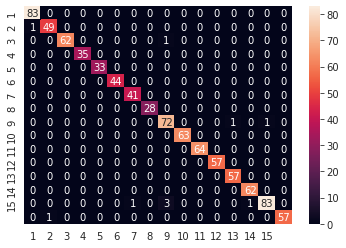

In [19]:
train_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train/'
train_augmented_path = '/content/drive/MyDrive/DS102-final-project/ball-data/train-augmented/'
test_path = '/content/drive/MyDrive/DS102-final-project/ball-data/test/'

cf_matrix = make_cm(train_path, test_path, model, 'histogram')

x_axis_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # labels for x-axis
y_axis_labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # labels for y-axis

sns.heatmap(cf_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)

In [ ]:
scores['param'][144]

[{'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 32,
  'max_features': 'auto',
  'min_samples_leaf': 2,
  'min_samples_split': 6,
  'n_estimators': 500,
  'random_state': 42}]

## ResNet50


In [ ]:
train_path = '/content/drive/MyDrive/COURSES/DS102-final-project/ball-data/train/'
train_augmented_path = '/content/drive/MyDrive/COURSES/DS102-final-project/ball-data/train-augmented/'
test_path = '/content/drive/MyDrive/COURSES/DS102-final-project/ball-data/test/'

isOversampled = 1
isAugmented = 0
resnet = 1

scores = classify_ball(train_path, train_augmented_path, test_path, 'flatten', isOversampled, isAugmented, resnet)

scores

Found 3120 validated image filenames belonging to 16 classes.
Found 226 validated image filenames belonging to 16 classes.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 8)    224         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 8)   0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 16, 16, 8)    584         ['m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/150
1/1 [==============================] - 10s 10s/step - loss: 2.8436 - accuracy: 0.0644 - val_loss: 2.4747 - val_accuracy: 0.1549 - lr: 0.0050


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/150
1/1 [==============================] - 8s 8s/step - loss: 2.5746 - accuracy: 0.1272 - val_loss: 2.2651 - val_accuracy: 0.3009 - lr: 0.0050
Epoch 3/150
1/1 [==============================] - 8s 8s/step - loss: 2.3083 - accuracy: 0.2074 - val_loss: 1.9115 - val_accuracy: 0.3451 - lr: 0.0050
Epoch 4/150
1/1 [==============================] - 8s 8s/step - loss: 1.9373 - accuracy: 0.3308 - val_loss: 1.8499 - val_accuracy: 0.3850 - lr: 0.0050
Epoch 5/150
1/1 [==============================] - 8s 8s/step - loss: 1.8212 - accuracy: 0.4103 - val_loss: 1.7076 - val_accuracy: 0.4292 - lr: 0.0050
Epoch 6/150
1/1 [==============================] - 8s 8s/step - loss: 1.6584 - accuracy: 0.4577 - val_loss: 1.4991 - val_accuracy: 0.4602 - lr: 0.0050
Epoch 7/150
1/1 [==============================] - 8s 8s/step - loss: 1.4978 - accuracy: 0.4772 - val_loss: 1.3923 - val_accuracy: 0.5265 - lr: 0.0050
Epoch 8/150
1/1 [==============================] - ETA: 0s - loss: 1.4176 - accuracy: 0.5186
E

[0.1548672616481781,
 0.3008849620819092,
 0.3451327383518219,
 0.3849557638168335,
 0.4292035400867462,
 0.4601770043373108,
 0.5265486836433411,
 0.3849557638168335,
 0.491150438785553,
 0.5442478060722351,
 0.6106194853782654,
 0.6283186078071594,
 0.6238937973976135,
 0.5752212405204773,
 0.5442478060722351,
 0.5486725568771362]

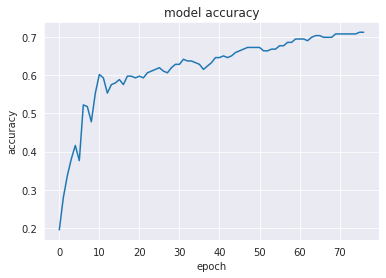

In [ ]:
plt.plot(scores)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig("plot/resnet50_plot.png")
plt.show()